![trader](trader.jpg)


Asset allocation is the most important decision that any investor needs to face. They need to decide how to spread their total capital over certain assets (in this case, stocks). When considering the allocation, the investor wants to balance the risk and the potential reward. At the same time, the allocation depends on factors such as individual goals, risk tolerance, and the investment horizon.

The key framework used in asset allocation is the Modern Portfolio Theory (MPT), which was introduced by the Nobel Prize winner Harry Markowitz. MPT describes how investors can construct portfolios to maximize their expected returns for a given level of risk or, conversely, minimize risk for a given level of expected return. The mathematical framework used to achieve this is called mean-variance optimization.

The main insight from MPT is that investors should not evaluate an asset’s performance alone. Instead, they should evaluate how it would impact the performance of a portfolio of assets. Another important takeaway is the concept of diversification, which means that owning different kinds of assets reduces risk. That is because the loss or gain of a particular security has less impact on the overall portfolio’s performance.

**Task**

In the dynamic realm of finance, data scientists/analysts are often tasked with finding optimal investment strategies. We were asked to build an effective portfolio comprising FAANG stocks – Facebook (Meta), Apple, Amazon, Netflix, and Google. Our goal is to maximize returns while mitigating risk.

In this project, we are tasked to find the optimal allocation to the FAANG stocks based on historical stock price data spanning the years 2020-2023. The dataset is stored in the `faang_stocks.csv` file. For each trading day, it contains the close prices of the five tech companies.


In [33]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
plt.style.use("seaborn-colorblind")

In [ ]:
# Loading data
stock_prices_df = pd.read_csv("faang_stocks.csv", index_col="Date")

# Changing the index to a datetime type allows for easier filtering and plotting.
stock_prices_df.index = pd.to_datetime(stock_prices_df.index)
stock_prices_df

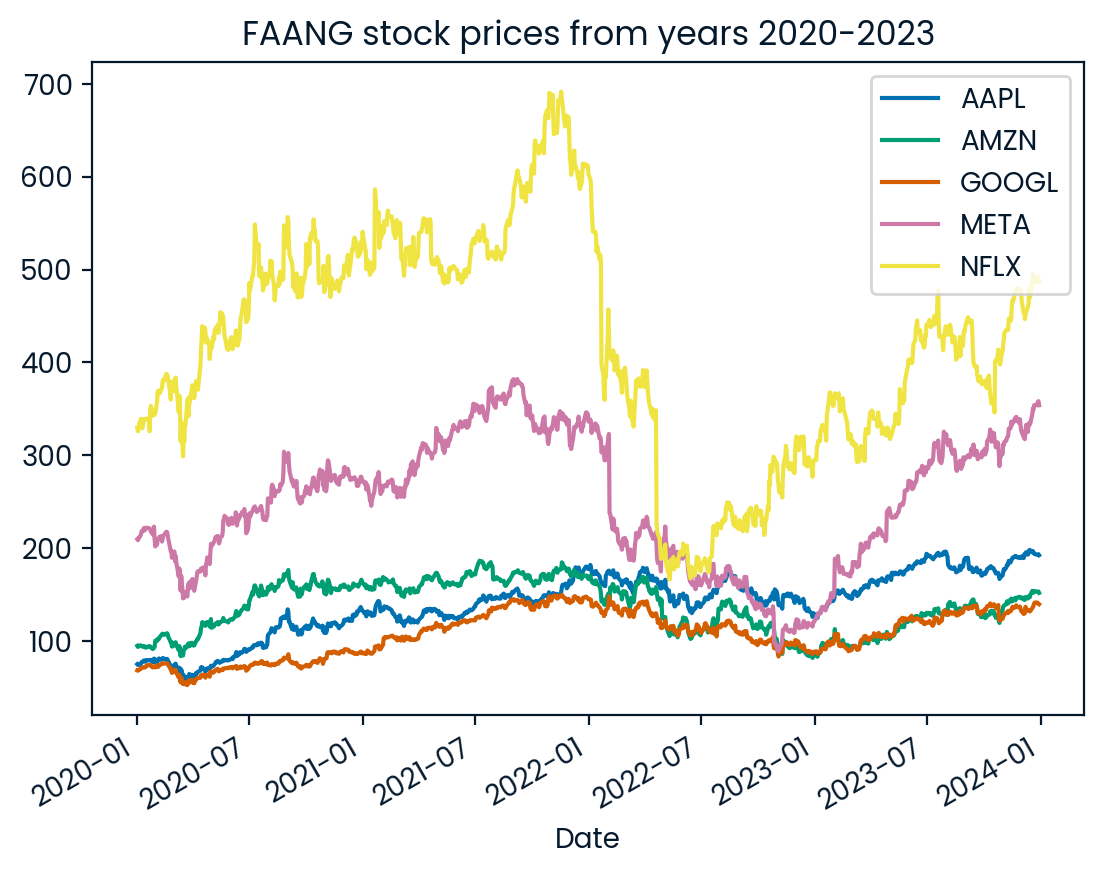

In [4]:
# Plotting the stock prices
stock_prices_df.plot(title="FAANG stock prices from years 2020-2023");

In [5]:
# Calculate expected annualized returns and sample covariance
mu = expected_returns.mean_historical_return(stock_prices_df)
Sigma = risk_models.sample_cov(stock_prices_df)

Optimal Weights:  OrderedDict([('AAPL', 0.95429), ('AMZN', 0.0), ('GOOGL', 0.04571), ('META', 0.0), ('NFLX', 0.0)])
Expected annual return: 26.3%
Annual volatility: 33.1%
Sharpe Ratio: 0.73


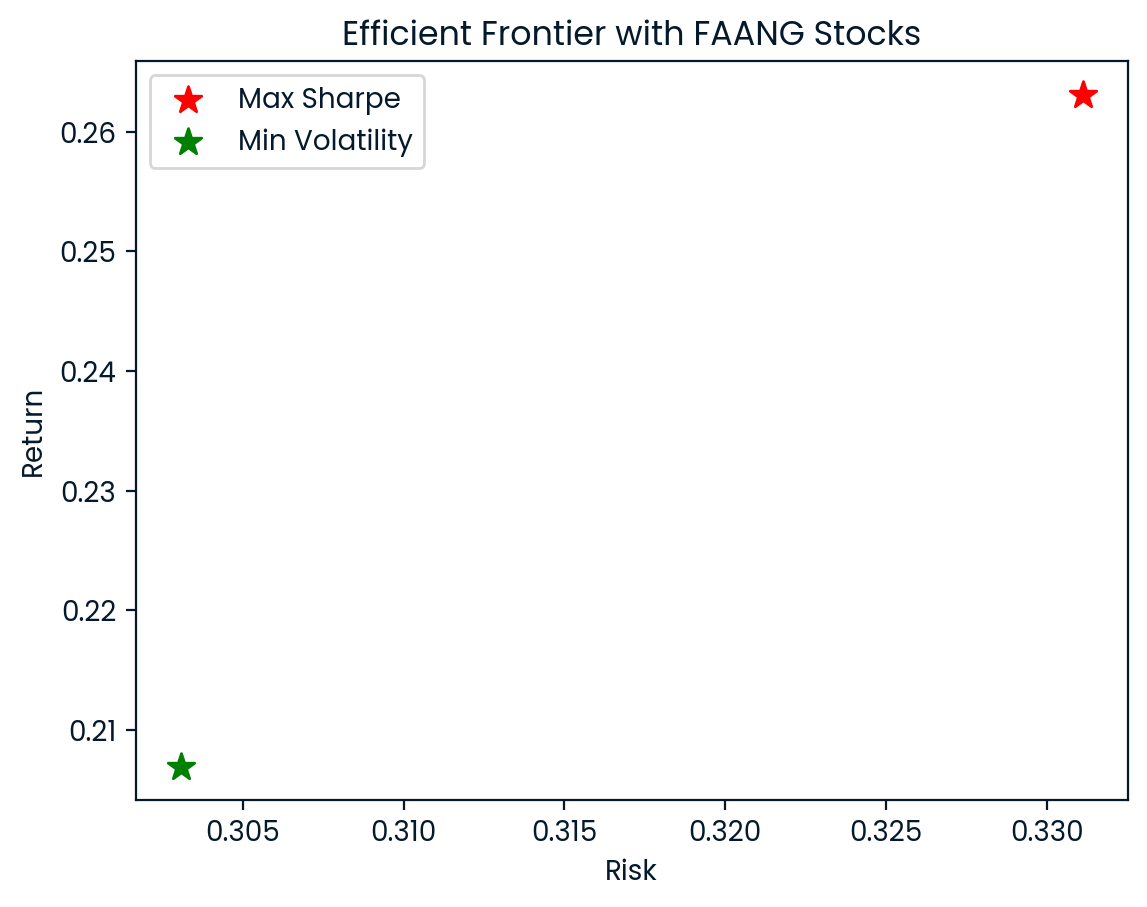

In [6]:
import pandas as pd
from pypfopt import EfficientFrontier, risk_models, expected_returns
import matplotlib.pyplot as plt

# Download historical data for FAANG stocks from 2020-2023
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']

# Calculate expected returns and the covariance matrix
mu = expected_returns.mean_historical_return(stock_prices_df)
S = risk_models.sample_cov(stock_prices_df)

# Optimize for the maximum Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print("Optimal Weights: ", cleaned_weights)

# Calculate the expected return, volatility, and Sharpe ratio
performance = ef.portfolio_performance(verbose=True)

# Plot the efficient frontier
def plot_efficient_frontier(mu, S):
    ef = EfficientFrontier(mu, S)
    fig, ax = plt.subplots()
    # Find the tangency portfolio
    ef = EfficientFrontier(mu, S)
    ef.max_sharpe()
    ret_tangent, std_tangent, _ = ef.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Find the minimum volatility portfolio
    ef = EfficientFrontier(mu, S)
    ef.min_volatility()
    ret_min_vol, std_min_vol, _ = ef.portfolio_performance()
    ax.scatter(std_min_vol, ret_min_vol, marker="*", s=100, c="g", label="Min Volatility")

    # Add legend
    ax.legend()
    plt.title('Efficient Frontier with FAANG Stocks')
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.show()

plot_efficient_frontier(mu, S)


In [8]:
performance

(0.2630771129547926, 0.33111344826011224, 0.7341203271328288)

[*********************100%%**********************]  5 of 5 completed
Optimal Weights:  [0.82110246 0.         0.17143811 0.         0.00745943]
Expected Portfolio Return:  0.2875003613451983
Expected Portfolio Risk:  0.31991668677797375


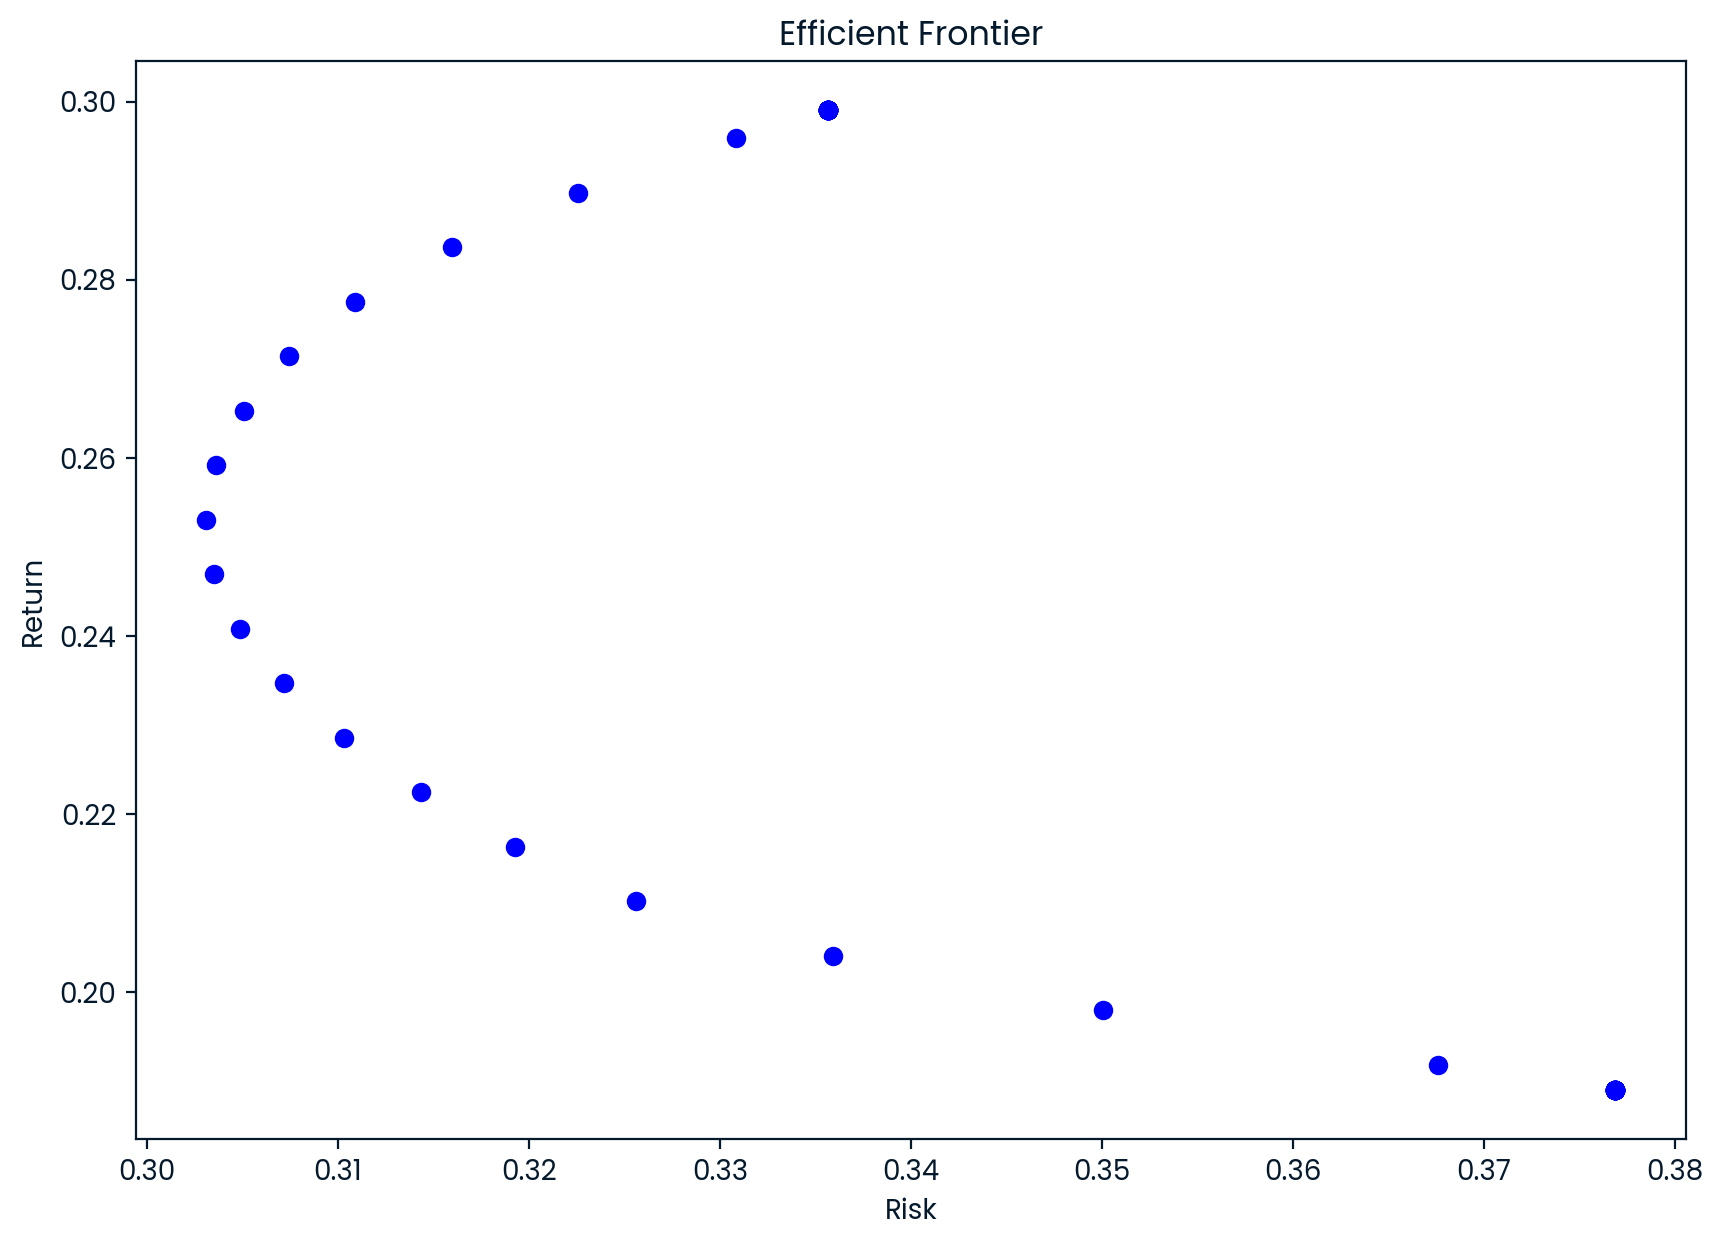

In [13]:


# Download historical data for FAANG stocks
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
data = stock_prices_df
# Calculate daily returns
returns = data.pct_change().dropna()

# Mean and covariance of returns
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Define the functions for portfolio optimization
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    std, returns = portfolio_performance(weights, mean_returns, cov_matrix)
    return - (returns - risk_free_rate) / std

def optimize_portfolio(mean_returns, cov_matrix, risk_free_rate=0):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(negative_sharpe_ratio, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Optimize the portfolio
optimal_portfolio = optimize_portfolio(mean_returns, cov_matrix)
optimal_weights = optimal_portfolio.x

# Display the results
print("Optimal Weights: ", optimal_weights)
print("Expected Portfolio Return: ", portfolio_performance(optimal_weights, mean_returns, cov_matrix)[1])
print("Expected Portfolio Risk: ", portfolio_performance(optimal_weights, mean_returns, cov_matrix)[0])

# Plot the efficient frontier
def plot_efficient_frontier(mean_returns, cov_matrix, risk_free_rate=0):
    results = []
    for return_target in np.linspace(0.1, 0.4, 50):
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                       {'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[1] - return_target}]
        bound = (0.0, 1.0)
        bounds = tuple(bound for asset in range(len(mean_returns)))
        result = minimize(lambda x: portfolio_performance(x, mean_returns, cov_matrix)[0], len(mean_returns) * [1. / len(mean_returns),],
                          method='SLSQP', bounds=bounds, constraints=constraints)
        results.append(result)
    
    plt.figure(figsize=(10, 7))
    for result in results:
        plt.scatter(result.fun, portfolio_performance(result.x, mean_returns, cov_matrix)[1], marker='o', color='b')
    plt.title('Efficient Frontier')
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.show()
    
    return results
results = plot_efficient_frontier(mean_returns, cov_matrix)


Optimal Weights:  OrderedDict([('AAPL', 0.95429), ('AMZN', 0.0), ('GOOGL', 0.04571), ('META', 0.0), ('NFLX', 0.0)])
Expected annual return: 26.3%
Annual volatility: 33.1%
Sharpe Ratio: 0.73


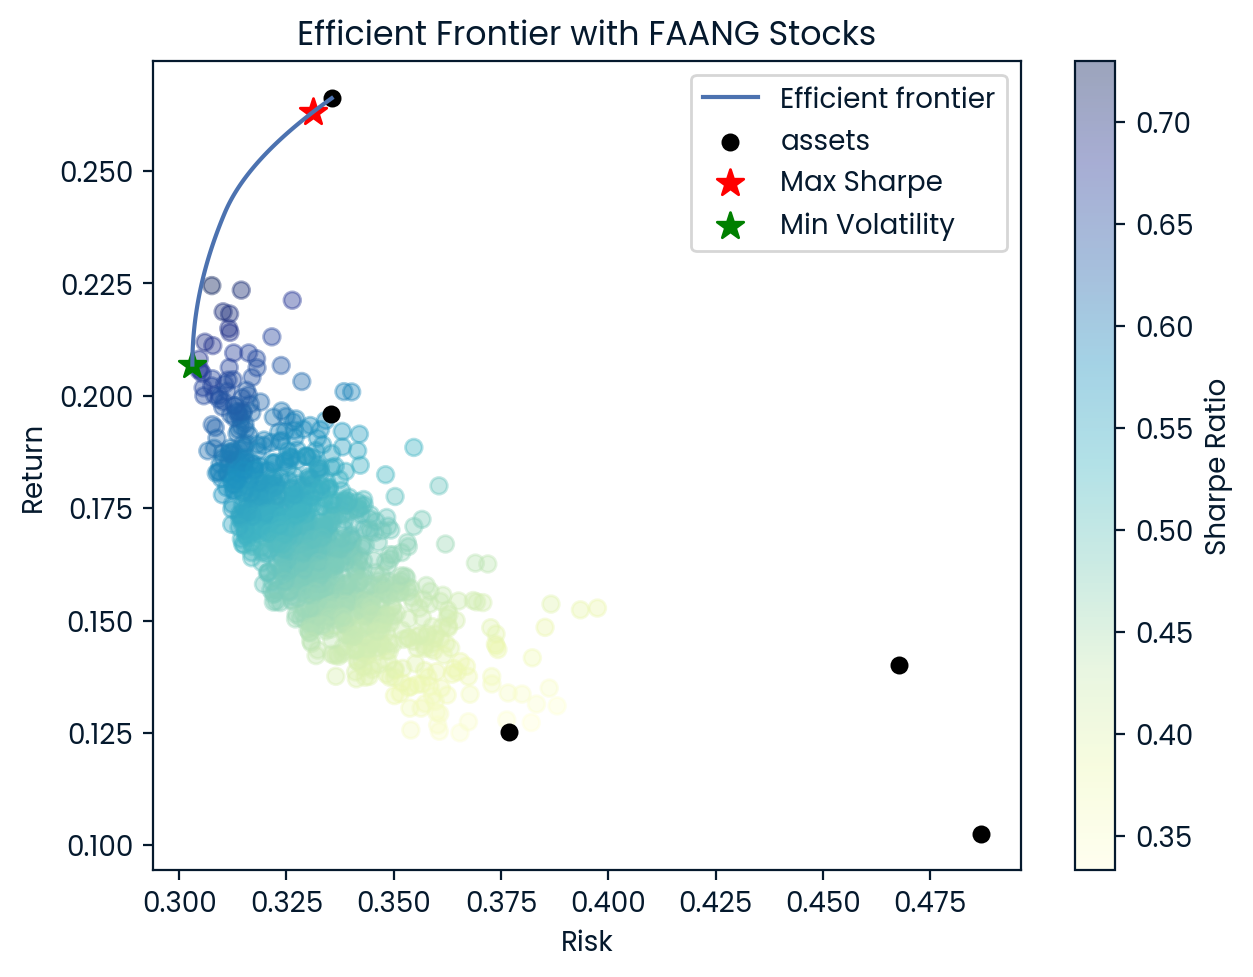

In [32]:
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
data = stock_prices_df
# Calculate expected returns and the covariance matrix
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

# Optimize for the maximum Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print("Optimal Weights: ", cleaned_weights)

# Calculate the expected return, volatility, and Sharpe ratio
performance = ef.portfolio_performance(verbose=True)

# Generate random portfolios
n_samples = 1000
results = np.zeros((n_samples, 3))
for i in range(n_samples):
    # Randomly generate weights
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    
    # Calculate portfolio return and volatility
    port_return = np.dot(weights, mu)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(S, weights)))
    sharpe_ratio = port_return / port_volatility
    
    results[i, 0] = port_volatility
    results[i, 1] = port_return
    results[i, 2] = sharpe_ratio

# Plot the efficient frontier and random portfolios
def plot_efficient_frontier_with_portfolios(mu, S, results):
    ef = EfficientFrontier(mu, S)
    fig, ax = plt.subplots()
    
    # Plot random portfolios
    mappable = ax.scatter(results[:, 0], results[:, 1], c=results[:, 2], cmap='YlGnBu', marker='o', alpha=0.4)
    
    # Plot efficient frontier
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True, c='r')
    fig.colorbar(mappable, ax=ax, label='Sharpe Ratio')
    # Find the tangency portfolio
    ef = EfficientFrontier(mu, S)
    ef.max_sharpe()
    ret_tangent, std_tangent, _ = ef.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Find the minimum volatility portfolio
    ef = EfficientFrontier(mu, S)
    ef.min_volatility()
    ret_min_vol, std_min_vol, _ = ef.portfolio_performance()
    ax.scatter(std_min_vol, ret_min_vol, marker="*", s=100, c="g", label="Min Volatility")

    # Add legend
    ax.legend()
    plt.title('Efficient Frontier with FAANG Stocks')
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.show()

plot_efficient_frontier_with_portfolios(mu, S, results)
